In [73]:
import torch
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
import numpy as np
from torchvision import datasets
from torchvision import transforms


Normalization and download the datasets

In [74]:
transform=transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.1307),(0.3081))])
train_dataset=datasets.MNIST(root='./data/mnist',train=True,download=True,transform=transform)
test_dataset=datasets.MNIST(root='./data/mnist',train=False,download=True,transform=transform)

Datasets demos

/Users/heshuyao/opt/anaconda3/lib/python3.9/site-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/Users/heshuyao/opt/anaconda3/lib/python3.9/site-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")


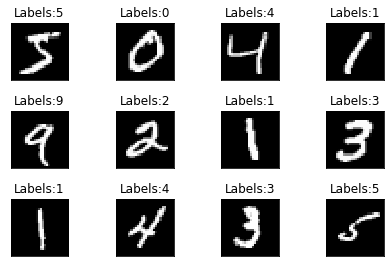

In [75]:
fig=plt.figure()
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.tight_layout()
    plt.imshow(train_dataset.train_data[i],cmap='gray',interpolation='none')
    plt.title("Labels:{}".format(train_dataset.train_labels[i]))
    plt.xticks([])
    plt.yticks([])
plt.show()

In [12]:
print(train_dataset.classes)

['0 - zero', '1 - one', '2 - two', '3 - three', '4 - four', '5 - five', '6 - six', '7 - seven', '8 - eight', '9 - nine']


In [76]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader

In [77]:
batch_size = 16
# Training sampler and data loader

train_dl = DataLoader(train_dataset,batch_size)

# Validation sampler and data loader

val_dl = DataLoader(test_dataset,batch_size)

Plot images in a sample batch of data.

In [78]:
from torchvision.utils import make_grid
def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(10,10))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, 8).permute(1, 2, 0), cmap='Greys_r')
        break

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


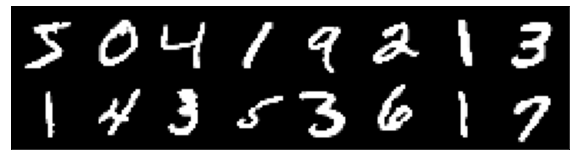

In [79]:
show_batch(train_dl)

In [80]:
# Import the libraries
import torch.nn as nn
import torch.nn.functional as F

from torchinfo import summary

In [81]:
class ImageClassifierNet(nn.Module):
    def __init__(self, n_channels=3):
        super(ImageClassifierNet, self).__init__()
        # sequential函数就是把里面的参数按顺序执行一下
        self.conv1 = nn.Sequential(
        # conv2d第一个参数：rgb的维度，1是黑白图
        # conv2d第二个参数：卷积的feature
        # conv2d第三个参数：kernal，卷积核的边长：奇数，根据图像大小和精度
        # conv2d第四个参数：kernal的步长，一般是1
        # padding一般是（卷积核的边长-1）/2
        # 10:卷积的feature；
        # 28*28:pixl
        nn.Conv2d(1, 10, 3, 1, padding=1),    # 经过conv2d输出变成(10, 28, 28)
        # 非线性层，把负数归零，整的保持不变
        nn.ReLU(),
        # 最大池化
        nn.MaxPool2d(2, 2)                    # 经过最大池化(10, 14, 14)
        )

        self.conv2 = nn.Sequential(
        nn.Conv2d(10, 30, 3, 1, padding=1),    # (30, 14, 14)
        nn.ReLU(),
        nn.MaxPool2d(2, 2)                    # (30, 7, 7)
        )

        self.linear1 = nn.Sequential(
        # 把一个30*7*7的三位矩阵拉成一个60*1的列向量
        nn.Linear(30 * 7 * 7, 60),
        # 选择性的去掉一些神经元，0.3，0.5都可
        nn.Dropout(0.2),
        nn.ReLU()
        )
        # 压缩成10*1的列向量，因为有10个数字
        self.linear2 = nn.Linear(60, 10)
        ######################
        
    def forward(self, X):
        X = self.conv1(X)
        X = self.conv2(X)
        X = X.view(-1, 30 * 7 * 7)
        X = self.linear1(X)
        # 
        X = F.log_softmax(self.linear2(X), dim=1)
        return X

In [82]:
model=ImageClassifierNet()

In [83]:
summary(model,input_size=(batch_size,1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
ImageClassifierNet                       [16, 10]                  --
├─Sequential: 1-1                        [16, 10, 14, 14]          --
│    └─Conv2d: 2-1                       [16, 10, 28, 28]          100
│    └─ReLU: 2-2                         [16, 10, 28, 28]          --
│    └─MaxPool2d: 2-3                    [16, 10, 14, 14]          --
├─Sequential: 1-2                        [16, 30, 7, 7]            --
│    └─Conv2d: 2-4                       [16, 30, 14, 14]          2,730
│    └─ReLU: 2-5                         [16, 30, 14, 14]          --
│    └─MaxPool2d: 2-6                    [16, 30, 7, 7]            --
├─Sequential: 1-3                        [16, 60]                  --
│    └─Linear: 2-7                       [16, 60]                  88,260
│    └─Dropout: 2-8                      [16, 60]                  --
│    └─ReLU: 2-9                         [16, 60]                  --
├─Linea

## Enable training on a GPU

In [84]:
def get_default_device():
    if torch.backends.mps.is_available():
        return torch.device('mps')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [85]:
device = get_default_device()
print(device)

to_device(model, device)

cpu


ImageClassifierNet(
  (conv1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(10, 30, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear1): Sequential(
    (0): Linear(in_features=1470, out_features=60, bias=True)
    (1): Dropout(p=0.2, inplace=False)
    (2): ReLU()
  )
  (linear2): Linear(in_features=60, out_features=10, bias=True)
)

## Train the model

In [86]:
def train_model(n_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr):
    """
    Trains the model on a dataset.
    
    Args:
        n_epochs: number of epochs
        model: ImageClassifierNet object
        train_dl: training dataloader
        val_dl: validation dataloader
        loss_fn: the loss function
        opt_fn: the optimizer
        lr: learning rate
    
    Returns:
        The trained model. 
        A tuple of (model, train_losses, val_losses, train_accuracies, val_accuracies)
    """
    # Record these values the end of each epoch
    train_losses, val_losses, train_accuracies, val_accuracies = [], [], [], []
    params = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = opt_fn(params, lr=lr)
    for i in range(n_epochs):
        model.train()
        sum_loss, correct, total = 0, 0, 0
        for x, y in train_dl:
            x, y = x.to(device), y.to(device)
            y_ = model(x)
            _, pred = torch.max(y_, 1)
            optimizer.zero_grad()
            loss = loss_fn(y_, y)
            loss.backward()
            optimizer.step()
            sum_loss += loss.item() * y.shape[0]
            correct += (pred == y).float().sum()
            total += y.shape[0]
        val_loss, val_acc = evaluate(model, val_dl, loss_fn)
        train_loss = sum_loss / total
        train_acc = float(correct) / total
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

    
    return model, train_losses, val_losses, train_accuracies, val_accuracies

def evaluate(model, val_dl, loss_fn):
    if len(val_dl) == 0:
        return 0, 0
    model.eval()
    correct, total, sum_loss = 0, 0, 0
    for x, y in val_dl:
        x, y = x.to(device), y.to(device)
        y_ = model(x)
        _, pred = torch.max(y_, 1)
        loss = loss_fn(y_, y)
        correct += (pred == y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item() * y.shape[0]
    return float(sum_loss) / total, float(correct) / total


**Set the maximum number of training epochs, the loss function, the optimizer, and the learning rate.**

In [87]:
num_epochs = 30# Max number of training epochs
loss_fn = F.nll_loss# Define the loss function
opt_fn = torch.optim.Adam # Select an optimizer
lr = 1e-4 # Set the learning rate

In [88]:
history = train_model(num_epochs, model, train_dl, val_dl, loss_fn, opt_fn, lr)
model, train_losses, val_losses, train_accuracies, val_accuracies = history

(tensor([[[-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242],
         [-0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242, -0.4242,
          -0.4242, -0.4242, -0.4242, -0.4242, -

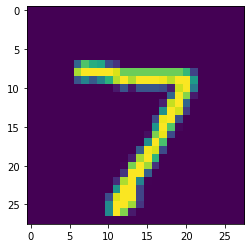

In [95]:
# squeeze()抹掉第一个维度，把1*28*28变成28*28
print(test_dataset[0])
plt.imshow(test_dataset[0][0].squeeze(0))


In [94]:
torch.argmax(model(test_dataset[0][0]))

tensor(7)

## Plot loss and accuracy

In [96]:
def plot_accuracy(train_accuracies, val_accuracies):
    """Plot accuracies"""
    plt.plot(train_accuracies, "-x")
    plt.plot(val_accuracies, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(["Training", "Validation"])
    plt.title("Accuracy vs. No. of epochs")

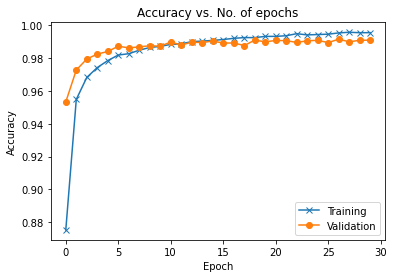

In [97]:
plot_accuracy(train_accuracies, val_accuracies)

In [98]:
def plot_losses(train_losses, val_losses):
    """Plot losses"""
    plt.plot(train_losses, "-x")
    plt.plot(val_losses, "-o")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(["Training", "Validation"])
    plt.title("Loss vs. No. of Epochs")

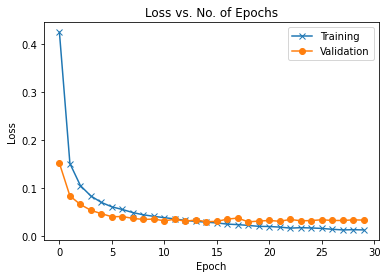

In [99]:
plot_losses(train_losses, val_losses)